In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *
from helpers.notebooks import notebooks_importer
# from helpers import developer_mode

In [2]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)

In [3]:
pd.options.mode.chained_assignment = None

## Load data & methods definitions

In [4]:
%%capture
import Breast_cancer_data as data_brca

### Set-up shared across tests

Following values were set as defaults for the test on BRCA cohort:

In [5]:
%%capture
from Benchmarking_setup import standard_benchmark

In [6]:
from functools import partial

In [7]:
brca_standard_benchmark = partial(
    standard_benchmark,
    # force the pipline to show full progress and use
    # my custom multiprocessing (which is more reliable)
    per_test_progress=True 
)

In [8]:
%%capture
from Selected_functions import (
    selected_single_sample_functions,
    selected_multi_sample_functions,
    selected_functions
)

Validation perturbations are retrieved from RepoDB, see [BRCA_results.ipynb](BRCA_results.ipynb).

In [13]:
%store -r validation_perturbations

In [14]:
from signature_scoring.evaluation.subtypes import subtypes_benchmark

In [15]:
brca_subtypes_benchmark_only_signatures = partial(
    subtypes_benchmark,
    benchmark_function=brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures,
    unassigned_signatures=validation_perturbations
)

In [16]:
brca_subtypes_benchmark = partial(
    brca_subtypes_benchmark_only_signatures,
    data_brca.brca_expression
)

### Previously reported BRCA stratification

Please refer to "Published BRCA stratifications.ipynb"

In [10]:
%%capture
import Published_BRCA_stratifications

In [11]:
from Published_BRCA_stratifications import (
    # this gets us the participant-cluster relation for different clustering methods
    all_stratifications,
    # this is one of them; different as based only on expression,
    # thus able to explor tumour heterogenity
    pam50_brca,
    stratifications_summary
)

In [12]:
stratifications_summary

,based_on,name,reference
id,,,
icluster,"[CNV, DNA methylation, mRNA, miRNA]",iCluster,"(Hoadley et al., 2018)"
subtype_mrna,[mRNA],PAM 50,"(TCGA Network, 2012)"
paradigm_clusters,"[CNV, mRNA, Pathways (NCIPID, BioCarta, Reacto...",PARADIGM,"(Berger et al., 2018)"
pan_gyn_clusters,[],Pan-Gyn,"(Berger et al., 2018)"


In [13]:
stratification_nice_names = {
    'nmf_expr': 'NMF (mRNA + miRNA)',
    'nmf_mrna': 'NMF (mRNA)',
    'No stratification': 'No stratification',
    **stratifications_summary.name.to_dict()
}

# Data generation

In [14]:
from signature_scoring.evaluation.analysis import normalize_scores
from signature_scoring.evaluation.reevaluation import extract_scores_from_result

## Scoring subtypes in each stratification

In [15]:
from data_sources.tcga import stratification
from signature_scoring.evaluation import permutations

In [16]:
from data_sources.tcga.stratification import get_subtype_by_sample, group_by_subtype

In [17]:
ss_stratification_results = {}
ms_stratification_results = {}

In [18]:
all_stratifications.group.unique()

array(['icluster', 'pan_gyn_clusters', 'paradigm_clusters',
       'subtype_mrna'], dtype=object)

### PAM 50

PAM 50 goes first it is the only one stratified on participant (not patient) level.

In [19]:
pam50_brca[['pan_samplesid', 'subtype_mrna', 'participant']]

,pan_samplesid,subtype_mrna,participant
407,TCGA-E2-A158-11A-22R-A12D-07,Normal,A158
408,TCGA-BH-A0DD-11A-23R-A12P-07,LumA,A0DD
409,TCGA-BH-A1EO-11A-31R-A137-07,LumA,A1EO
410,TCGA-BH-A0B5-11A-23R-A12P-07,LumA,A0B5
411,TCGA-A7-A13G-11A-51R-A13Q-07,LumA,A13G
...,...,...,...
1620,TCGA-UL-AAZ6-01A-11R-A41B-07,LumA,AAZ6
1621,TCGA-S3-AA0Z-01A-11R-A41B-07,Basal,AA0Z
1622,TCGA-UU-A93S-01A-21R-A41B-07,Her2,A93S
1623,TCGA-BH-A0H9-11A-22R-A466-07,Normal,A0H9


In [20]:
pam50_subtype_sample_df = get_subtype_by_sample(data_brca.brca_expression, pam50_brca, subtype_column='subtype_selected')
pam50_subtype_sample_df.head()

1212 matched exactly on sample ID
0 not matched


,sample,subtype_selected
0,TCGA-3C-AAAU-01A-11R-A41B-07,BRCA.LumA
1,TCGA-3C-AALI-01A-11R-A41B-07,BRCA.Her2
2,TCGA-3C-AALJ-01A-31R-A41B-07,BRCA.LumB
3,TCGA-3C-AALK-01A-11R-A41B-07,BRCA.LumA
4,TCGA-4H-AAAK-01A-12R-A41B-07,BRCA.LumA


In [21]:
pam50_samples_by_type = group_by_subtype(pam50_subtype_sample_df, subtype_column='subtype_selected')

In [22]:
NeatNamespace(pam50_samples_by_type)

BRCA.Basal,"['TCGA-A1-A0SK-01A-12R-A084-07', 'TCGA-A1-A0SO-01A-22R-A084-07', 'TCGA-A1-A0S, ..., 11R-A41B-07', 'TCGA-S3-AA10-01A-21R-A41B-07', 'TCGA-S3-AA15-01A-11R-A41B-07'], 191 in total"
BRCA.Her2,"['TCGA-3C-AALI-01A-11R-A41B-07', 'TCGA-A2-A04W-01A-31R-A115-07', 'TCGA-A2-A04, ..., 11R-A28M-07', 'TCGA-OL-A66P-01A-11R-A31O-07', 'TCGA-UU-A93S-01A-21R-A41B-07'], 82 in total"
BRCA.LumA,"['TCGA-3C-AAAU-01A-11R-A41B-07', 'TCGA-3C-AALK-01A-11R-A41B-07', 'TCGA-4H-AAA, ..., 11R-A36F-07', 'TCGA-XX-A89A-01A-11R-A36F-07', 'TCGA-Z7-A8R5-01A-42R-A41B-07'], 579 in total"
BRCA.LumB,"['TCGA-3C-AALJ-01A-31R-A41B-07', 'TCGA-5T-A9QA-01A-11R-A41B-07', 'TCGA-A1-A0S, ..., 32R-A32P-07', 'TCGA-S3-AA17-01A-11R-A41B-07', 'TCGA-Z7-A8R6-01A-11R-A41B-07'], 219 in total"
BRCA.Normal,"['TCGA-A1-A0SB-01A-11R-A144-07', 'TCGA-A2-A0CL-01A-11R-A115-07', 'TCGA-A2-A0C, ..., 21R-A28M-07', 'TCGA-OL-A97C-01A-32R-A41B-07', 'TCGA-PL-A8LY-01A-11R-A41B-07'], 141 in total"


In [ ]:
pam50_brca_results_ss = brca_subtypes_benchmark(
    pam50_samples_by_type,
    funcs=selected_single_sample_functions
)
pam50_brca_results_ms = brca_subtypes_benchmark(
    pam50_samples_by_type,
    funcs=selected_multi_sample_functions
)

In [ ]:
ss_stratification_results['subtype_mrna'] = pam50_brca_results_ss
ms_stratification_results['subtype_mrna'] = pam50_brca_results_ms

### Permutations generation

In [30]:
from signature_scoring.evaluation.subtypes import random_subtypes_benchmark
from signature_scoring.evaluation import permutations

Please see [Permutation_generation.ipynb](Permutation_generation.ipynb) for permutation generation details.

In [32]:
from signature_scoring.evaluation.subtypes_analysis import load_pickled_permutations

### Other previously published BRCA stratifications

In [21]:
all_stratifications

,participant,cluster,group
4826,A0T0,IC10,icluster
4953,A08R,IC10,icluster
5051,A0FJ,IC10,icluster
5084,A0J6,IC10,icluster
5138,A1AH,IC10,icluster
...,...,...,...
1578,A8FZ,Normal,subtype_mrna
1583,A8HR,Normal,subtype_mrna
1592,A9QF,Normal,subtype_mrna
1605,A97C,Normal,subtype_mrna


In [103]:
samples_by_statification_and_subtype = {}
for name, stratification in all_stratifications.groupby('group'):
    if name == 'subtype_mrna':
        continue

    print(name)
    subtype_sample_df = get_subtype_by_sample(
        data_brca.brca_expression, stratification,
        subtype_column='cluster'
    )
    samples_by_type = group_by_subtype(
        subtype_sample_df, subtype_column='cluster'
    )
    samples_by_statification_and_subtype[name] = samples_by_type

icluster
1142 matched by participant ID
70 not matched
pan_gyn_clusters
981 matched by participant ID
231 not matched
paradigm_clusters
1166 matched by participant ID
46 not matched


In [336]:
# %store samples_by_statification_and_subtype

Stored 'samples_by_statification_and_subtype' (dict)


In [23]:
%store -r samples_by_statification_and_subtype

In [ ]:
for name, samples_by_type in samples_by_statification_and_subtype.items():
    ss_stratification_results[name] = brca_subtypes_benchmark(
        samples_by_type,
        funcs=selected_single_sample_functions
    )
    ms_stratification_results[name] = brca_subtypes_benchmark(
        samples_by_type,
        funcs=selected_multi_sample_functions
    )

### NMF

In [33]:
%store -r brca_expression_based_nmf_sub_types

In [49]:
brca_expression_based_nmf_sub_types

,cluster
TCGA-3C-AAAU-01A-11R-A41B-07,0
TCGA-3C-AALI-01A-11R-A41B-07,0
TCGA-3C-AALJ-01A-31R-A41B-07,0
TCGA-3C-AALK-01A-11R-A41B-07,0
TCGA-4H-AAAK-01A-12R-A41B-07,0
...,...
TCGA-WT-AB44-01A-11R-A41B-07,0
TCGA-XX-A899-01A-11R-A36F-07,1
TCGA-XX-A89A-01A-11R-A36F-07,1
TCGA-Z7-A8R5-01A-42R-A41B-07,0


In [52]:
def nmf_samples_by_type(stratification):
    stratification.index.name = 'index'
    return (
        stratification
        .reset_index()
        .groupby('cluster')['index'].apply(list).to_dict()
    )

In [53]:
nmf_mrna_samples_by_type = nmf_samples_by_type(brca_expression_based_nmf_sub_types)

In [54]:
NeatNamespace(nmf_mrna_samples_by_type)

0,"['TCGA-3C-AAAU-01A-11R-A41B-07', 'TCGA-3C-AALI-01A-11R-A41B-07', 'TCGA-3C-AAL, ..., 11R-A41B-07', 'TCGA-Z7-A8R5-01A-42R-A41B-07', 'TCGA-Z7-A8R6-01A-11R-A41B-07'], 1831 in total"
1,"['TCGA-3C-AALK-01A-11R-A41B-07', 'TCGA-4H-AAAK-01A-12R-A41B-07', 'TCGA-5L-AAT, ..., 11R-A41B-07', 'TCGA-XX-A899-01A-11R-A36F-07', 'TCGA-XX-A89A-01A-11R-A36F-07'], 263 in total"
2,"['TCGA-A1-A0SD-01A-11R-A115-07', 'TCGA-A2-A04R-01A-41R-A109-07', 'TCGA-A2-A0D, ..., 11R-A31O-07', 'TCGA-PL-A8LX-01A-11R-A41B-07', 'TCGA-S3-A6ZH-01A-22R-A32P-07'], 52 in total"
3,"['TCGA-A2-A04Q-01A-21R-A034-07', 'TCGA-A2-A0CL-01A-11R-A115-07', 'TCGA-A2-A0C, ..., 21R-A41B-07', 'TCGA-S3-AA15-01A-11R-A41B-07', 'TCGA-S3-AA17-01A-11R-A41B-07'], 84 in total"
4,"['TCGA-A1-A0SM-01A-11R-A084-07', 'TCGA-A1-A0SQ-01A-21R-A144-07', 'TCGA-A2-A04, ..., 12R-A29R-07', 'TCGA-LL-A6FP-01A-11R-A31O-07', 'TCGA-OK-A5Q2-01A-11R-A27Q-07'], 44 in total"
5,['TCGA-GI-A2C8-11A-22R-A16F-07']
6,"['TCGA-3C-AALI-01A-11R-A41B-07', 'TCGA-A1-A0SG-01A-11R-A144-07', 'TCGA-A2-A0C, ..., 11R-A21T-07', 'TCGA-GM-A2DH-01A-11R-A180-07', 'TCGA-GM-A2DL-01A-11R-A18M-07'], 149 in total"


In [ ]:
nmf_mrna_brca_results_ss = brca_subtypes_benchmark(
    nmf_mrna_samples_by_type,
    funcs=selected_single_sample_functions
)
# %store nmf_mrna_brca_results_ss

In [30]:
%store -r nmf_mrna_brca_results_ss

In [ ]:
nmf_mrna_brca_results_ms = brca_subtypes_benchmark(
    nmf_samples_by_type,
    funcs=selected_multi_sample_functions
)
%store nmf_mrna_brca_results_ms

In [ ]:
ss_stratification_results['nmf_mrna'] = nmf_mrna_brca_results_ss
ms_stratification_results['nmf_mrna'] = nmf_mrna_brca_results_ms

### Multi-omics NMF

In [38]:
%store -r brca_multiomics_based_nmf_sub_types

In [65]:
subtype_sample_df = get_subtype_by_sample(
    data_brca.brca_expression, brca_multiomics_based_nmf_sub_types.reset_index().rename({'index': 'participant'}, axis=1),
    subtype_column='cluster'
)
samples_by_type = group_by_subtype(
    subtype_sample_df, subtype_column='cluster'
)

1448 matched by participant ID
-236 not matched


In [ ]:
nmf_expr_brca_results_ss = brca_subtypes_benchmark(
    samples_by_type,
    funcs=selected_single_sample_functions
)
%store nmf_expr_brca_results_ss

In [ ]:
nmf_expr_brca_results_ms = brca_subtypes_benchmark(
    nmf_multiomics_samples_by_type,
    funcs=selected_multi_sample_functions
)

In [ ]:
ss_stratification_results['nmf_expr'] = nmf_expr_brca_results_ss
ms_stratification_results['nmf_expr'] = nmf_expr_brca_results_ms

## Scores extraction

In [36]:
from signature_scoring.evaluation.subtypes_analysis import get_all_scores

In [38]:
scores_all_stratifications = [
    *get_all_scores(ss_stratification_results, by_cell=True),
    *get_all_scores(ms_stratification_results, by_cell=False)
]

scores_all_stratifications = concat(scores_all_stratifications)

In [ ]:
# %store scores_all_stratificationsa

In [24]:
%store -r scores_all_stratifications

In [ ]:
# note: not included in the analysis at the time of thesis write-up due to time constraints,
# though essentialy ready to be investigated in detail 
#nmf_simple = get_all_scores(
#    {
#        'nmf_mrna': nmf_mrna_brca_results_ss,
#        'nmf_expr': nmf_expr_brca_results_ss
#    }
#, by_cell=True)

In [35]:
#scores_all_stratifications = concat([scores_all_stratifications, *nmf_simple])

In [25]:
scores_all_stratifications = scores_all_stratifications.drop('Index', axis=1).reset_index(drop=True)

In [36]:
scores_all_stratifications

,cell_id,func,group,is_indication,pert_idose,pert_iname,raw_score,score,stratification,subtype
0,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,doxorubicin,129.807215,0.621099,icluster,IC10
1,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,epirubicin,129.304073,0.618470,icluster,IC10
2,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,everolimus,103.118575,0.481651,icluster,IC10
3,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,neratinib,97.274341,0.451115,icluster,IC10
4,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,tamoxifen,94.950195,0.438971,icluster,IC10
...,...,...,...,...,...,...,...,...,...,...
49537,NaN,roast_score,contraindications,False,10 µM,loxapine,-0.031838,-0.461820,subtype_mrna,BRCA.Normal
49538,NaN,roast_score,contraindications,False,10 µM,fluoxetine,-0.032282,-0.462550,subtype_mrna,BRCA.Normal
49539,NaN,roast_score,contraindications,False,100 nM,triflupromazine,-0.039953,-0.475156,subtype_mrna,BRCA.Normal
49540,NaN,roast_score,contraindications,False,10 µM,triflupromazine,-0.039953,-0.475156,subtype_mrna,BRCA.Normal


In [37]:
scores_all_stratifications.to_csv('scores_all_stratifications.csv')

In [38]:
scores_all_stratifications.head()

,cell_id,func,group,is_indication,pert_idose,pert_iname,raw_score,score,stratification,subtype
0,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,doxorubicin,129.807215,0.621099,icluster,IC10
1,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,epirubicin,129.304073,0.618470,icluster,IC10
2,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,everolimus,103.118575,0.481651,icluster,IC10
3,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,neratinib,97.274341,0.451115,icluster,IC10
4,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,10 µM,tamoxifen,94.950195,0.438971,icluster,IC10


### Reference (with no stratification)

Note: not using sel_scores, as these are already aggregated!

In [46]:
#%store -r mss_scores

In [26]:
%store -r sss_scores

In [40]:
brca_standard_benchmark = partial(
    standard_benchmark,
    
    # query (breast cancer differential profile) for single-sample functions 
    query_signature=data_brca.query_signature,
    # query (breast cancer normalized expression data) for multi-sample functions:
    query_expression=data_brca.brca_with_controls,
    
    # force the pipline to show full progress and use
    # my custom multiprocessing (which is more reliable)
    per_test_progress=True 
)

In [41]:
brca_minimal_benchmark = partial(
    # this is absolute minimum to say if the scoring function has any value
    # note: using contraindications, not controls as:
    # - there are not controls for controls for multi-sample functions
    # - controls (DMSO) seem to have very little biological effect
    brca_standard_benchmark,
    indications_signatures=data_brca.indications_singatures,
    contraindications_signatures=data_brca.contraindications_singatures
)

In [37]:
results_multi_sample_repeats = []
for i in range(25):
    results_multi_sample = brca_minimal_benchmark(
        selected_multi_sample_functions
    )
    results_multi_sample_repeats.append(results_multi_sample)    
%store results_multi_sample_repeats

In [27]:
%store -r results_multi_sample_repeats

In [28]:
len(results_multi_sample_repeats)

25

In [29]:
mss_scores_repeats = []
for i, result in enumerate(results_multi_sample_repeats):
    results_scores = extract_scores_from_result(
        result['meta:Scores'],
        are_grouped_by_cell=False,
        scores_as_series=False
    ).assign(
        repeat=i
    )
    mss_scores_repeats.append(results_scores)
mss_scores_repeats = concat(mss_scores_repeats)

Note: sss_scores are scores of single sample functions but **without controls** (for fair comparison with mss), thus will have different AUC/log loss than on the performance figure (A). But the trends should be the same.

In [30]:
scores_of_selected_functions = concat([
    normalize_scores(sss_scores, rescale=True, by_cell=True).assign(kind='single sample'),
    normalize_scores(mss_scores_repeats, rescale=True, by_cell=False).assign(kind='multi sample')
]).drop('Index', axis=1).reset_index(drop=True)
scores_of_selected_functions['repeat'] = scores_of_selected_functions['repeat'].fillna(0)
scores_of_selected_functions['subtype'] = '-'

In [31]:
from Plotting import nice_names_for

Importing Jupyter notebook from Plotting.ipynb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
nice_names = nice_names_for(scores_of_selected_functions.func)
NeatNamespace(nice_names)

connectivity_score_signature_cramér_von_mises_difference,"""CS'_{Cramér–von Mises}"""
score_spearman,"""Spearman'"""
x_sum,'XSum'
roast_score,'mROAST'
cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise,'cudaGSEA_{Reactome}'
cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise,'cudaGSEA_{hallmarks}'


### From permutations

In [48]:
def iter_permutations(all_stratifications, verbose=True):
    for name, stratification in all_stratifications.groupby('group'):
        if verbose:
            print(name)
        ss_permutations = load_pickled_permutations(prefix=f'ss_{name}')
        ms_permutations = load_pickled_permutations(prefix=f'ms_{name}')
        for permutations, is_single_sample in [(ss_permutations, True), (ms_permutations, False)]:
            yield permutations, is_single_sample, name

First, I count how many permutations I managed to generate:

In [60]:
permutations_count = []
for permutations, _, name in iter_permutations(all_stratifications, False):
    for permutation in permutations:
        for subtype, df in permutation.items():
            for func in df.index:
                permutations_count.append([name, subtype, func])

In [61]:
df = DataFrame(data=permutations_count, columns=['stratification', 'subtype', 'func'])
df['count'] = 1
df.func = df.func.map(nice_names)

There should be equal number or permutations for given function in each subtype of a stratification:

In [62]:
def same_values_in_subtype(subtypes_values):
    values = subtypes_values['count'].unique()
    assert len(values) == 1
    return list(values)[0]

dfs = (
    df
    .groupby(['stratification', 'subtype', 'func'])
    .count()
    .reset_index()
    .groupby(['stratification', 'func'])
    .apply(same_values_in_subtype)
)

In [63]:
dfs.reset_index().pivot(index='stratification', columns='func', values=0)

func,CS'_{Cramér–von Mises},Spearman',XSum,cudaGSEA_{Reactome},cudaGSEA_{hallmarks},mROAST
stratification,,,,,,
icluster,201,201,201,60,60,208
pan_gyn_clusters,201,201,201,50,50,208
paradigm_clusters,201,201,201,50,50,208
subtype_mrna,200,200,200,70,70,208


Let's use 200 single sample + 50 cuda + 200 mROAST.

In [64]:
limits = {
    'connectivity_score_signature_cramér_von_mises_difference': 200,
    'score_spearman': 200,
    'x_sum': 200,
    'roast_score': 200,
    'cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise': 50,
    'cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise': 50
}

In [67]:
from collections import Counter

scores_all_permutations = []
counter = Counter()

for permutations, by_cell, name in iter_permutations(all_stratifications):
    for i, permutation in tqdm(enumerate(permutations), total=len(permutations)):
        
        # apply limits
        any_left = False
        for subtype, df in permutation.items():
            
            for func in df.index:
                if counter[name, func] >= limits[func]:
                    df.drop(func, inplace=True)
                else:
                    counter[name, func] += 1
                    any_left = True

        if any_left:
            permutation_i_scores = get_all_scores(
                {f'{name} permutations ({i})': permutation},
                by_cell=by_cell
            )
            scores_all_permutations.extend(permutation_i_scores)

scores_all_permutations = concat(scores_all_permutations)

icluster


/home/krassowski/drug_discovery/code/signature_scoring/evaluation/subtypes_analysis.py:42: UserWarning: IC3 of icluster permutations (11) has no scores for this permutation
  warn(f'{subtype} of {stratification} has no scores for this permutation')



pan_gyn_clusters



paradigm_clusters



subtype_mrna


In [75]:
DataFrame([
    {
        'stratification': stratification,
        'func': nice_names[func],
        'count': count
    }
    for (stratification, func), count in counter.items()
]).pivot(index='stratification', columns='func', values='count')

func,CS'_{Cramér–von Mises},Spearman',XSum,cudaGSEA_{Reactome},cudaGSEA_{hallmarks},mROAST
stratification,,,,,,
icluster,200,200,200,50,50,200
pan_gyn_clusters,200,200,200,50,50,200
paradigm_clusters,200,200,200,50,50,200
subtype_mrna,200,200,200,50,50,200


In [145]:
scores_all_permutations = scores_all_permutations.reset_index(drop=True).drop('Index', axis=1)

In [148]:
scores_all_permutations.to_csv('scores_all_permutations.csv')

In [147]:
#%store scores_all_permutations

Stored 'scores_all_permutations' (DataFrame)


In [33]:
%store -r scores_all_permutations

### Adding the reference scores

In [34]:
scores_with_reference = concat([
    scores_all_stratifications,
    scores_of_selected_functions.assign(stratification='No stratification')
]).reset_index(drop=True)

In [35]:
scores_with_reference['is_indication'] = scores_with_reference.group == 'indications'

In [36]:
# these does not really matter but prevents nans from causing trouble (esp on conversion to R)
scores_with_reference.loc[scores_with_reference.kind.isna(), 'kind'] = '-'

In [37]:
scores_with_reference.head()

,cell_id,func,group,is_indication,kind,...,raw_score,repeat,score,stratification,subtype
0,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,-,...,129.807215,NaN,0.621099,icluster,IC10
1,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,-,...,129.304073,NaN,0.618470,icluster,IC10
2,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,-,...,103.118575,NaN,0.481651,icluster,IC10
3,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,-,...,97.274341,NaN,0.451115,icluster,IC10
4,HA1E,connectivity_score_signature_cramér_von_mises_...,indications,True,-,...,94.950195,NaN,0.438971,icluster,IC10


And renaming functions to plot-friendly strings:

In [38]:
scores_with_reference.func = scores_with_reference.func.replace(nice_names)
scores_with_reference.func = pd.Categorical(
    scores_with_reference.func,
    ordered=True,
    categories=nice_names.values()
)

In [39]:
scores_with_reference.score.describe()

count    177092.000000
mean         -0.054194
std           0.340020
min          -1.000000
25%          -0.310148
50%          -0.103516
75%           0.187996
max           1.000000
Name: score, dtype: float64

## Stratifications comparison

In [40]:
from signature_scoring.evaluation.analysis import compute_metrics_by_func, compute_metrics

In [41]:
from signature_scoring.evaluation.subtypes_analysis import (
    aggregate_scores_per_substance_strat_func,
    metrics_by_stratification,
    prepare_metrics_for_plotting,
    rename_for_plot
)

In [42]:
def measure_permutations_performance(permutation_scores, trans, rename_category_to=None):

    scores_max_random = aggregate_scores_per_substance_strat_func(permutation_scores, trans=trans)

    # first, measure metrics for each permutation individually, then move them available to a single category
    random_metrics = metrics_by_stratification(scores_max_random)
    
    if not rename_category_to:
        random_metrics.stratification = random_metrics.stratification.apply(lambda n: n.split(' ')[0])
    else:
        random_metrics.stratification = rename_category_to

    random_metrics = prepare_metrics_for_plotting(
        random_metrics,
        nice_names,
        stratification_nice_names
    )
    random_metrics.is_permutation = True
    return random_metrics

### Stratifications performance on average

I do not expect any significant improvements when averaging scores over the subtypes

In [43]:
observed_scores_clean = scores_with_reference.dropna(subset=['score'])
permutation_scores_clean = scores_all_permutations.dropna(subset=['score'])

In [44]:
(len(scores_all_permutations) - len(permutation_scores_clean)) / len(permutation_scores_clean) * 100

5.798940095765354

In [45]:
(len(scores_with_reference) - len(observed_scores_clean)) / len(observed_scores_clean)

0.0

In [46]:
permutation_scores_clean.score.describe()

count    1.267473e+06
mean    -7.905027e-02
std      3.372962e-01
min     -1.000000e+00
25%     -2.807616e-01
50%     -9.719327e-02
75%      1.298825e-01
max      1.000000e+00
Name: score, dtype: float64

In [47]:
def scale_scores(full_scores, groupby):
    return concat([
        normalize_scores(scores, rescale=True, by_cell=False).assign(
            **dict(zip(groupby, group_values))
        )
        for group_values, scores in full_scores.groupby(groupby)
    ]).reset_index(drop=True)


def df_per_substance(df):
    df.score = df.groupby(['pert_iname', 'stratification', 'subtype', 'func']).score.transform('mean')
    df = df[df.columns.difference(['pert_idose', 'cell_id', 'raw_score'])]
    assert not df.score.isna().any()
    return df.drop_duplicates().reset_index(drop=True)


def performance_when_aggregating_with(
    transformation='mean', scale='within_subtypes',
    per_substance=True, cell_line=None,
    observed_scores_clean=observed_scores_clean,
    permutation_scores_clean=permutation_scores_clean
):
    assert scale in {'within_subtypes', None, 'globally'}
    
    if cell_line:
        observed_scores_clean = observed_scores_clean[observed_scores_clean.cell_id==cell_line]
        permutation_scores_clean = permutation_scores_clean[permutation_scores_clean.cell_id==cell_line]
        
    if scale == 'within_subtypes':
        scores = scale_scores(observed_scores_clean, groupby=['stratification', 'subtype', 'func'])
        permutation_scores = scale_scores(permutation_scores_clean, groupby=['stratification', 'subtype', 'func'])
    elif scale == 'globally':
        # should change nothing (it should already be in this state)!
        scores = scale_scores(observed_scores_clean, groupby=['stratification', 'func'])
        permutation_scores = scale_scores(permutation_scores_clean, groupby=['stratification', 'func'])
    else:
        scores = copy(observed_scores_clean)
        permutation_scores = copy(permutation_scores_clean)

    no_stratification_scores = scores[scores.stratification == 'No stratification']
    stratification_scores = scores[scores.stratification != 'No stratification']

    no_stratification_scores.stratification = (
        no_stratification_scores.stratification
        + ' permutations '  # more like "repeats", but anyway
        + no_stratification_scores.repeat.astype(str)
    )
    
    # average to obtain per-substance scores
    if per_substance:
        stratification_scores = df_per_substance(stratification_scores)
        no_stratification_scores = df_per_substance(no_stratification_scores)
        permutation_scores = df_per_substance(permutation_scores)
        
    if hasattr(transformation, 'requiers_full_data'):
        stratification_scores_transformation = partial(transformation, df=stratification_scores)
        no_stratification_scores_transformation = partial(transformation, df=no_stratification_scores)
        permutation_transformation = partial(transformation, df=permutation_scores)
    else:
        no_stratification_scores_transformation = transformation
        stratification_scores_transformation = transformation
        permutation_transformation = transformation

    polish = partial(
        prepare_metrics_for_plotting,
        nice_names=nice_names,
        stratification_nice_names=stratification_nice_names
    )

    scores_agg = aggregate_scores_per_substance_strat_func(
        stratification_scores,
        stratification_scores_transformation
    )
    
    assert not no_stratification_scores.empty

    avg_plt_metrics_all = concat([
        polish(
            metrics_by_stratification(scores_agg)
        ).assign(is_permutation=F),
        measure_permutations_performance(
            no_stratification_scores,
            trans=no_stratification_scores_transformation,
            rename_category_to='No stratification'
        ).assign(is_permutation=F),
        measure_permutations_performance(
            permutation_scores,
            trans=permutation_transformation
        ).assign(is_permutation=T)
    ])

    return avg_plt_metrics_all, scores_agg

In [48]:
all_statifications_samples = {
    'subtype_mrna': pam50_samples_by_type,
    #'nmf_mrna': nmf_mrna_samples_by_type,
    #'nmf_expr': nmf_multiomics_samples_by_type,
    'No stratification': {'-': [1]},
    **samples_by_statification_and_subtype
}

In [49]:
total_count_in_stratification = {
    stratification: sum([
        len(samples)
        for samples in samples_by_subtypes.values()
    ])
        
    for stratification, samples_by_subtypes in all_statifications_samples.items()
}

In [50]:
weights = {
    stratification: {
        subtype: len(samples) / total_count_in_stratification[stratification]
        for subtype, samples in samples_by_subtypes.items()
    }
    for stratification, samples_by_subtypes in all_statifications_samples.items()
}

In [51]:
NeatNamespace(weights)

subtype_mrna,"{'BRCA.Basal': 0.15759075907590758, 'BRCA.Her2': 0.06765676567656766, 'BRCA.L, ..., 2772277, 'BRCA.LumB': 0.1806930693069307, 'BRCA.Normal': 0.11633663366336634}, 5 in total"
No stratification,{'-': 1.0}
icluster,"{'IC10': 0.01576182136602452, 'IC13': 0.06567425569176882, 'IC14': 0.01751313, ..., 035026269702276708, 'IC7': 0.009632224168126095, 'IC8': 0.009632224168126095}, 12 in total"
pan_gyn_clusters,"{'C1': 0.3343527013251784, 'C2': 0.05708460754332314, 'C3': 0.22629969418960244, 'C4': 0.16615698267074414, 'C5': 0.2161060142711519}"
paradigm_clusters,"{'PRC2': 0.0686106346483705, 'PRC4': 0.23499142367066894, 'PRC5': 0.34133790737564323, 'PRC6': 0.2658662092624357, 'PRC8': 0.08919382504288165}"


In [52]:
import numpy

def weighted_metric(metric):
    def calc_metric(scores, df):
        stratification = scores.name[2]
        
        df = df.loc[scores.index]
        assert (scores.values == df.score.values).all()
        
        df = df.dropna(subset=['score']) 
        scores = df.score
        
        if not len(scores):
            return numpy.nan

        if 'No stratification' in stratification:
            return metric(scores)
        
        if 'permutations' in stratification:
            stratification = stratification.split(' ')[0]

        return metric(scores * df.subtype.map(weights[stratification]))
    calc_metric.requiers_full_data = True
    return calc_metric

In [53]:
weighted_mean = weighted_metric(Series.mean)

In [197]:
%%R
source('../../helpers/plots/utilities.R')

no_correction = function(var, func){ 0 }


comparison_plot = function(data, subset, label, reference, dir, stratifications_data, two_tailed=T, correction=no_correction) {

    d = data[data$variable %in% subset,]
    r = d[d$stratification==reference,]
    d = d[d$stratification!=reference,]
    permutations = d[d$is_permutation==T,]
    observed = d[d$is_permutation==F,]
    
    #startification_names = prepre_stratification_names(stratifications_data)
    # calculate p-values
    m = merge(observed, permutations, by=c('func', 'stratification', 'variable'), suffixes=c('_obs', '_perm'))
    if (two_tailed) {
        m[,'less_extreme'] = 1 - ((m$value_obs) * dir > abs(m$value_perm) * dir)
    }
    else {
        m[,'less_extreme'] = 1 - (m$value_obs * dir > m$value_perm * dir)
    }
    p_values = aggregate(
        list(p_value=m[,'less_extreme']),
        by=list(
            func=m$func,
            stratification=m$stratification,
            variable=m$variable
        ),
        mean
    )
    print(p_values[p_values$p_value < 0.06,])
    p_values_with_meta = merge(p_values, observed)
    
    # filter out non-siginficant points
    pp = p_values_with_meta[p_values_with_meta$p_value <= 0.1 | p_values_with_meta$p_value >= 0.9,]
    
    # calculate optimal position for p-value placement 
    pp_and_random = merge(pp, permutations, by=c('func', 'stratification', 'variable'), suffixes=c('_p', ''))
    cols = c('value', 'func')
    b = rbind(pp[,cols], pp_and_random[,cols])
    mi = aggregate(list(max=b[,'value']), list(func=b$func), max)
    ma = aggregate(list(min=b[,'value']), list(func=b$func), min)
    pp = merge(mi, pp)
    pp = merge(ma, pp)
    
    ci_mean <- function(x) {
        Hmisc::smean.cl.boot(x)
    }
    ci_upper <- function(x) {
        Hmisc::smean.cl.boot(x)['Upper']
    }
    ci_lower <- function(x) {
        Hmisc::smean.cl.boot(x)['Lower']
    }
    
    r_mean = do.call(data.frame,
        aggregate(
            subset(r, select=c('value')),
            by=list(func=r$func, variable=r$variable),
            FUN=ci_mean
        )
    )
    
    (
        ggplot(
            observed,
            aes(x=stratification, y=value, fill=stratification)
        )
        + facet_grid(~func, scales='free_y', labeller=label_parsed)
        + stat_summary(geom='bar', fun.y=mean, position=position_dodge(0.9))
        + geom_rect(
            data=r_mean,
            aes(
                ymin=value.Lower, ymax=value.Upper,
                fill='95% CI',
                xmin=-Inf, xmax=Inf, x=1, y =1
            ),
            fill='#888888',
            alpha=0.2
        )
        + geom_violin(
            data=permutations,
            position=position_dodge(0.9),
            fill='white', width=0.5,
            alpha=0.5, color='#666666'
        )
        + theme(
            legend.position='bottom',
            legend.box='horizontal',
            text=element_text(size=15),
            axis.text.x=element_text(angle=90)
        )
        + ylab(label)
        + geom_hline(
            data=r_mean,
            aes(yintercept=value.Upper, linetype='95% CI'),
            color='#999999', alpha=0
        )
        + geom_hline(
            data=r_mean, aes(yintercept=value.Mean, linetype='Mean'),
            color='#888888'
        )
        + scale_linetype_manual(
            name='No stratification',
            values=c("solid", "dashed"),
            guide=guide_legend(
                title.position='left',
                direction='vertical',
                override.aes=list(
                    color=c('#888888', '#888888'),
                    alpha=c(0.2, 1),
                    size=c(2, 1/2)
                )
            )
        )
        + scale_y_continuous(labels=function(x) sprintf('%.1f', as.numeric(x)))
        + ggthemes::scale_fill_tableau(
            labels=startification_names,
            guide=(fill=guide_legend(
                title='Stratification',
                label.hjust=0,
                label.theme=element_text(
                    size=11,
                    margin=margin(t=-.15, b=-0.15, u='cm', l=-0.05, r=0.05)
                ),
                order=1
            ))
        )
        + shadowtext::geom_shadowtext(
            data=pp,
            aes(
                label=ifelse(
                    p_value > 0.5,
                    ifelse(abs(1-p_value) < 0.05, '××', '×'),
                    ifelse(p_value < 0.05, '∗∗', '∗')
                ),
                y=max,
                vjust=(1-dir)*0.5 - 0.5*dir + correction(variable, func),
                color=ifelse(p_value>0.5, '#D62728', '#2CA02C'),
                size=ifelse(p_value>0.5, 4.8, 6.2)
            ),
            bg.color='white',
            bg.r=0.03
        )
        + scale_color_identity()
        + scale_size_identity()
        + xlab('Scoring functions applied to BRCA stratifications')
    )
}

In [55]:
stratifications_summary
stratifications = stratifications_summary[['name', 'reference']]

In [56]:
%%R -i stratifications

startification_names <- function (x) {
        lapply(x, function(y) {
            reference = stratifications[stratifications$name == y,]['reference']
            s <- latex2exp::TeX(y, 'character')
            w <- latex2exp::TeX(sprintf('\\small{%s}', reference), 'character')
            x = sprintf('atop(NA,atop(textstyle(%s), atop(%s, NA)))', s, w)
            parse(text=x)
        })
    }

auc_log_plot = function(stratification_metrics, reference='No stratification', auc_max=.8, log_loss_max=NA, corr=no_correction) {
    levels(stratification_metrics$func) = latex_levels(stratification_metrics, 'func')
    auc = (
        comparison_plot(stratification_metrics, 'auc', 'AUC ROC', reference, dir=+1, correction=corr, stratifications_data=stratifications)
    )

    log_loss = (
        comparison_plot(stratification_metrics, 'log_loss', 'Log loss', reference, dir=-1, correction=corr, stratifications_data=stratifications)
        + scale_y_reverse(labels=function(x) sprintf('%.1f', as.numeric(x)), limits=c(log_loss_max, 0))

    )
    
    (
        cowplot::plot_grid(
            (
                auc
                + theme(
                    legend.position="top",
                    axis.ticks.x=element_blank(),
                    axis.text.x=element_blank(),
                    legend.title=element_text(size=12),
                    plot.margin=margin(unit='cm', l=0.5, r=0.5, t=0.1),
                    legend.margin=margin(unit='cm', b=-0.15)
                )
                + xlab('')
                + coord_cartesian(ylim=c(.5,auc_max))
            ),
            (
                log_loss
                + theme(
                    legend.position="none", 
                    plot.margin=margin(t=-0.5, unit='cm', l=0.5, r=0.5, b=0.2),
                    axis.title.x=element_text(vjust=-0.5)
                )
            ),
            nrow=2
        )
    )
}

In [57]:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning, message=".*Scale for 'y' is already present.*")
warnings.filterwarnings("ignore", category=RRuntimeWarning, message=".*Ignoring unknown aesthetics.*")

In [58]:
weighted_mean_metrics, weighted_mean_scores = performance_when_aggregating_with(
    weighted_mean,          # subtype gets as much votes as many it has participants
    per_substance=True,
    scale='within_subtypes' # each subtype is "forced" to decide
                            # (value normalized are to [-1, 1])
                            # no place for "I do not know answers"
)

In [59]:
%store weighted_mean_metrics
%store weighted_mean_scores

Stored 'weighted_mean_metrics' (DataFrame)
Stored 'weighted_mean_scores' (DataFrame)


First, make sure there are all 25 repeats without stratification:

In [64]:
ms_names = ['cudaGSEA_{Reactome}', 'mROAST', 'cudaGSEA_{hallmarks}']

In [65]:
def reference_repeats(metrics):
    return metrics.query(
        "func in @ms_names and stratification == 'No stratification'"
    ).groupby(['func', 'variable']).count().reset_index().query(
        "func in @ms_names and variable in ['auc', 'log_loss']"
    ).value.unique()

In [67]:
assert reference_repeats(weighted_mean_metrics) == 25

In [60]:
def mean_differences(metrics, variables=['auc', 'log_loss'], by='func', permutations=False):
    results = {}
    metrics = metrics[~metrics.is_permutation]
    metrics.func = metrics.func.astype(str) 
    metrics.stratification = metrics.stratification.astype(str) 
    for variable in metrics.variable.unique():
        if variable not in variables:
            continue
        variable_metrics = metrics[metrics.variable == variable]
        with_stratification = variable_metrics.stratification != 'No stratification'
        without_st = variable_metrics[~with_stratification].groupby(by).value.mean()
        with_strat = variable_metrics[with_stratification].groupby(by).value.mean()
        without_st.loc['overall'] = without_st.mean()
        with_strat.loc['overall'] = with_strat.mean()
        results[variable + '_without'] = without_st
        results[variable + '_with'] = with_strat
        if 'stratification' in by:
            key_names = with_strat.index.names
            for key in with_strat.index:
                if 'overall' in key:
                    continue
                without_key = dict(zip(key_names, key))
                without_key['stratification'] = 'No stratification'
                without_key = tuple(without_key.values())
                without_st.loc[key] = without_st.loc[without_key]
            
            #without_st.index = .loc['No stratification']
        results[variable + '_diff'] = with_strat - without_st
        results[variable + '_diff_%'] = (with_strat - without_st) / abs(with_strat) * 100
    df = DataFrame(results)
    return df

In [61]:
show_table(
    mean_differences(
        weighted_mean_metrics, by='stratification'
    ).style.highlight_min(axis=0)
)

,auc_without,auc_with,auc_diff,auc_diff_%,log_loss_without,log_loss_with,log_loss_diff,log_loss_diff_%
No stratification,0.64477,nan,nan,nan,0.960659,nan,nan,nan
PAM 50,0.64477,0.627502,-0.0172676,-2.7518,0.960659,0.689238,-0.271421,-39.3799
PARADIGM,0.64477,0.631782,-0.0129879,-2.05575,0.960659,0.689416,-0.271243,-39.3439
Pan-Gyn,0.64477,0.626165,-0.0186052,-2.97129,0.960659,0.688472,-0.272186,-39.5348
iCluster,0.64477,0.638426,-0.00634398,-0.993691,0.960659,0.690769,-0.269889,-39.0709
overall,0.64477,0.630969,-0.0138012,-2.1873,0.960659,0.689474,-0.271185,-39.3322


In [62]:
show_table(
    mean_differences(
        weighted_mean_metrics, by=['func', 'stratification']
    ).style.highlight_min(axis=0)
)

In [63]:
mean_differences(weighted_mean_metrics).style.highlight_min(axis=1)

,auc_without,auc_with,auc_diff,auc_diff_%,log_loss_without,log_loss_with,log_loss_diff,log_loss_diff_%
func,,,,,,,,
CS'_{Cramér–von Mises},0.620209,0.626307,0.00609756,0.973574,0.712006,0.686095,-0.0259112,-3.77663
Spearman',0.627178,0.612805,-0.0143728,-2.34542,0.695081,0.688426,-0.00665518,-0.966724
XSum,0.630662,0.638502,0.00783972,1.22783,0.56079,0.668158,0.107368,16.0692
cudaGSEA_{Reactome},0.59242,0.565789,-0.0266308,-4.70683,1.09524,0.722024,-0.373218,-51.6905
cudaGSEA_{hallmarks},0.642406,0.642857,0.000451128,0.0701754,1.05086,0.707727,-0.343136,-48.4842
mROAST,0.701734,0.699554,-0.00218086,-0.31175,0.772436,0.664414,-0.108022,-16.2583
overall,0.635768,0.630969,-0.00479934,-0.76063,0.814403,0.689474,-0.124929,-18.1195


/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown aesthetics: x, y

  warnings.warn(x, RRuntimeWarning)


           func stratification variable p_value
3 paste("XSum")       iCluster      auc    0.00
9 paste("XSum")         PAM 50      auc    0.05
[1] func           stratification variable       p_value       
<0 rows> (or 0-length row.names)


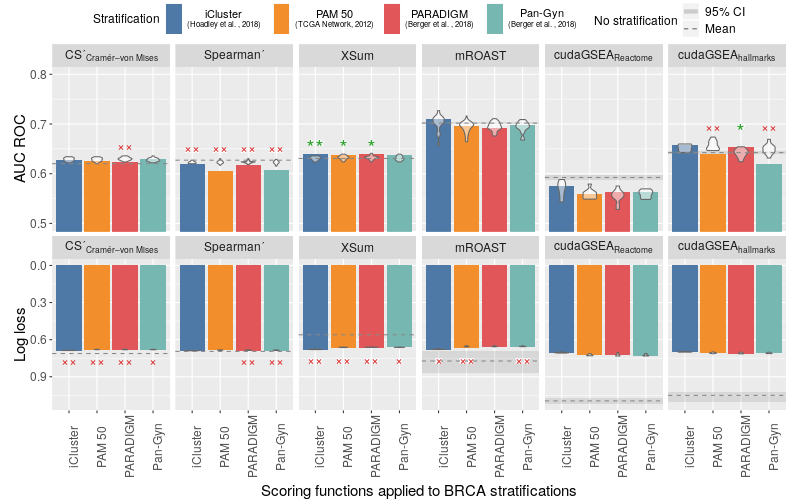

In [68]:
%%R -i weighted_mean_metrics -w 800 -h 500 -u px -p 150

g = auc_log_plot(weighted_mean_metrics)
ggsave(file="stratification_performance_weighted_mean_scores.png", plot=g, width=8*1.3, height=5*1.3, dpi=140)
g

Grey line indicates the values obtained without any stratification. Green asterisks indicate performance better than of a random permutation of a cancer samples, at a suggestive (\*, p < 0.1) or indicative (\*\* p < 0.05) level of significance; red crosses indicate performance worse than random at a  suggestive (×, p < 0.1) or indicative (××, p < 0.05) level of significance. The white violin plots present distribution of the values for random permutations.

Interpretation:
- look at the grey line. If the bars end above the grey line, we have an improvement over the reference "no stratification" result;
- then look at the random permutations. Are the values of metrics better than if we just taken a random permutation?

For single sample functions there is limited benefit from stratification - as expected.

Multi-sample functions, which are using gene sets, do benefit from the stratification which is a nice thing to find out. The original idea was that this will happen because the correctly stratified subtypes will enable detection of signal from gene sets of interest (which are subtype specific).

Importantly the reference "no-stratification" line is close to the median values of random subsets - this boosts the confidence that this model indeed works.

Additionally, confidence intervals for multi-sample functions' metrics are shown now (as these have some inherent variance due to the permutations testing etc). Assessed with only 25 repeats, but better something than nothing.

#### Validation of per_substance=False

This should be very similar as the one above (mean of means ~= mean)

In [69]:
weighted_mean_metrics_no_aggregation, _ = performance_when_aggregating_with(
    weighted_mean,          # subtype gets as much votes as many it has participants
    per_substance=False,
    scale='within_subtypes' # each subtype is "forced" to decide
                            # (value normalized are to [-1, 1])
                            # no place for "I do not know" answers
)
assert reference_repeats(weighted_mean_metrics_no_aggregation) == 25

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown aesthetics: x, y

  warnings.warn(x, RRuntimeWarning)


           func stratification variable p_value
3 paste("XSum")       iCluster      auc    0.00
9 paste("XSum")         PAM 50      auc    0.05
[1] func           stratification variable       p_value       
<0 rows> (or 0-length row.names)


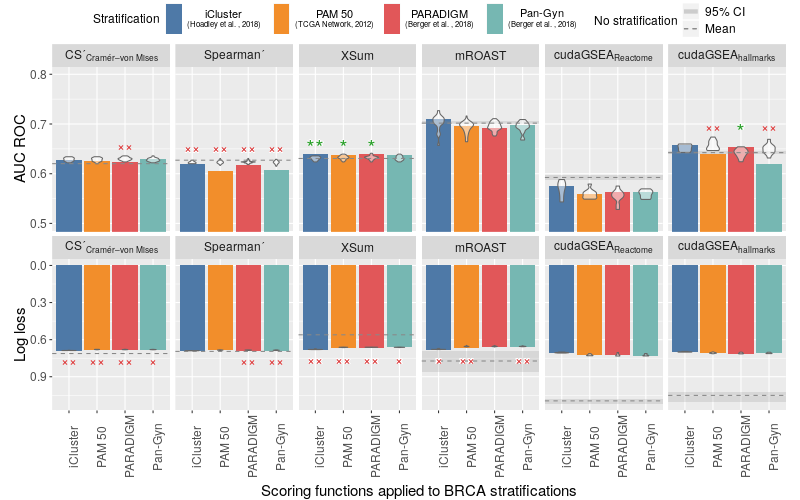

In [70]:
%%R -i weighted_mean_metrics_no_aggregation -w 800 -h 500 -u px -p 150

g = auc_log_plot(weighted_mean_metrics_no_aggregation)
g

#### Validation: without scaling

In [71]:
not_scaled_weighted_mean_metrics, _ = performance_when_aggregating_with(
    weighted_mean, scale=None
)
assert reference_repeats(not_scaled_weighted_mean_metrics) == 25

Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1


/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown aesthetics: x, y

  warnings.warn(x, RRuntimeWarning)


           func stratification variable p_value
3 paste("XSum")       iCluster      auc       0
9 paste("XSum")         PAM 50      auc       0
[1] func           stratification variable       p_value       
<0 rows> (or 0-length row.names)


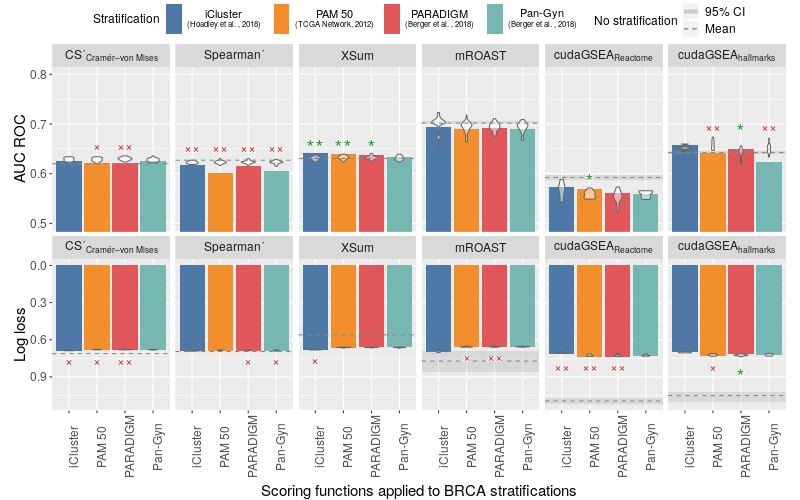

In [72]:
%%R -i not_scaled_weighted_mean_metrics -w 800 -h 500 -u px -p 150

g = auc_log_plot(not_scaled_weighted_mean_metrics)
# ggsave(file="stratification_performance_weighted_mean_scores_no_scale.png", plot=g, width=8*1.3, height=5*1.3, dpi=140)
g

When we allow the methods to "decide" if there is anything interesting in given subtype, we gain on log loss, especially of GSEA methods (which take advantage of significance estimation by permutation testing) - as expected.

The ROC AUC are down as for BRCA there ARE multiple subtype specific drugs, so if we do not encourage selection of subtype-specific findings, the ROC AUC goes down. A new observation, though somehow expected.

### Taking the maximal score across subtypes

If score 1 represents a drug candidate, and we accept that the drugs we are after may only work in one of the subtypes, one may want to only look at the maximum scores:

In [73]:
max_metrics, max_scores = performance_when_aggregating_with(
    Series.max,
    per_substance=True,
    scale='within_subtypes'
)
assert reference_repeats(max_metrics) == 25

Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sure the scores are -1/+1
Make sur

In [75]:
x = max_metrics[max_metrics.stratification=='Pan-Gyn']
x[x.is_permutation==False]
x

,func,stratification,variable,value,is_permutation
6,CS'_{Cramér–von Mises},Pan-Gyn,auc,0.623693,False
7,Spearman',Pan-Gyn,auc,0.665505,False
8,XSum,Pan-Gyn,auc,0.648084,False
9,mROAST,Pan-Gyn,auc,0.685714,False
10,cudaGSEA_{Reactome},Pan-Gyn,auc,0.567669,False
...,...,...,...,...,...
2107,XSum,Pan-Gyn,log_loss,0.573454,True
2108,CS'_{Cramér–von Mises},Pan-Gyn,log_loss,0.661982,True
2109,mROAST,Pan-Gyn,log_loss,0.606370,True
2110,Spearman',Pan-Gyn,log_loss,0.702387,True


In [76]:
mean_differences(max_metrics).style.highlight_min(axis=1)

,auc_without,auc_with,auc_diff,auc_diff_%,log_loss_without,log_loss_with,log_loss_diff,log_loss_diff_%
func,,,,,,,,
CS'_{Cramér–von Mises},0.620209,0.621951,0.00174216,0.280112,0.712006,0.750704,0.0386984,5.15494
Spearman',0.627178,0.638066,0.0108885,1.70648,0.695081,0.768546,0.0734651,9.55897
XSum,0.630662,0.634582,0.00391986,0.617708,0.56079,0.630701,0.0699107,11.0846
cudaGSEA_{Reactome},0.59242,0.555451,-0.0369691,-6.65569,1.09524,1.64832,0.553074,33.5539
cudaGSEA_{hallmarks},0.642406,0.62547,-0.0169361,-2.70774,1.05086,2.6993,1.64843,61.069
mROAST,0.701734,0.645089,-0.0566451,-8.78098,0.772436,1.17661,0.404172,34.3506
overall,0.635768,0.620102,-0.0156666,-2.52646,0.814403,1.27903,0.464625,36.3264


In [193]:
show_table(
    mean_differences(
        max_metrics, by=['func', 'stratification']
    ).style.highlight_min(axis=0)
)

                                                                      func
9                                                            paste("XSum")
13 paste("CS", minute, "", phantom()[{\n    paste("Cramér–von Mises")\n}])
14                                           paste("Spearman", minute, "")
15                                                           paste("XSum")
20                                           paste("Spearman", minute, "")
21                                                           paste("XSum")
   stratification variable p_value
9          PAM 50      auc   0.050
13       PARADIGM      auc   0.000
14       PARADIGM      auc   0.000
15       PARADIGM      auc   0.000
20        Pan-Gyn      auc   0.000
21        Pan-Gyn      auc   0.025
[1] func           stratification variable       p_value       
<0 rows> (or 0-length row.names)


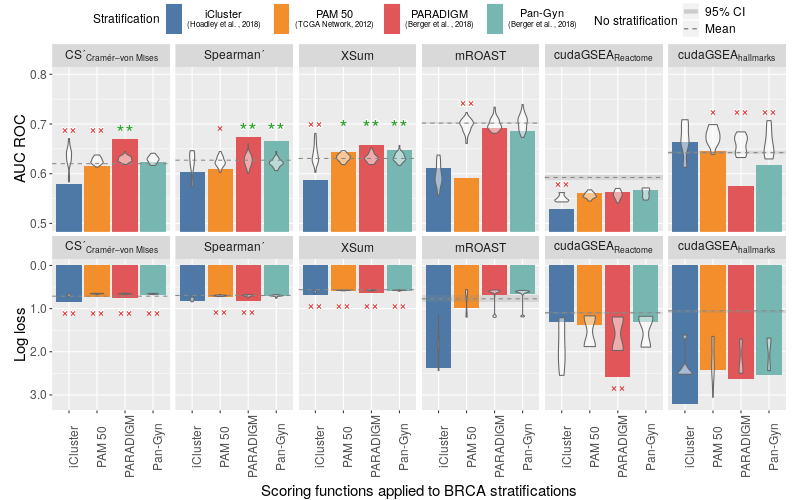

In [198]:
%%R -i max_metrics -w 800 -h 500 -u px

g = auc_log_plot(max_metrics)
ggsave(file="stratification_performance_max_scores.png", plot=g, width=8*1.3, height=5*1.3, dpi=140)
g

This gets very interesting now, especially the dominance of PARADIGM (but not so clear in GSEA)! Due to lack of time the simple answer is "the stratification matters". At least when the criterion is max.

1. What are dominant pathwyas in iCluster subtypes with hallmarks, esp when compared to Reactome?

### Taking the "best" score across subtypes

One could note that score -1 represents a substance more likely to be a contraindication.
I propose the best score to be an extreme one (if a drug treats at least one subtype, it is a good drug), but correcting for cases in which high variance (if a drug is a contraindication in at least one subtype it may be a bad drug, as due to cancer heterogeneity the subtypes are likely to coexist within a single tumour; one would not want a drug to treat one cancer but cause another).

In [77]:
from math import sqrt

In [78]:
ms = sqrt(2)  # maximal possible std deviation for [-1, +1]

def best_subtype_specific_repositioning_candidate(x):
    # best subtype-specific repositioning candidate, BSSRC
    x = x.dropna()
    if len(x) < 2:
        return numpy.nan
    
    s = x.std()

    assert s <= ms

    return (
        (x * x.abs()) # give more weight to the extreme effects (drugs or contraindications)
        .mean()       # average the effects
        *
        (ms - s)      # peanalise highly variable drugs; if a drug is extremely variable,
                      # it may treat one subtype but cause another - we don't know if it
                      # would be of any use; if it is not variable at all it may be a great
                      # drug or a very strong contraindication, or a strong control - anyway, no need to correct
        / ms          # keep within [-1, +1]
    )

This is a parametric model (the power p may be adjusted to change the weight of the subtype specific drugs).

In [79]:
def bssrc_generalized(x):
    
    # I will apply the function to the "no stratification" case too, hence the safeguard
    if 'No stratification' in x.name[2]:
        return x

    return best_subtype_specific_repositioning_candidate(x)

As we know that there are drugs for many subtypes, using 'within_subtypes' scaling:

In [80]:
bssrc_metrics, bssrc_scores = performance_when_aggregating_with(
    bssrc_generalized,      # each subtype gets a full vote, regardles of number of participants
    per_substance=True,
    scale='within_subtypes' # each subtype is "forced" to decide
                            # (value normalized are to [-1, 1])
                            # no place for "I do not know answers"

)
assert reference_repeats(bssrc_metrics) == 25

              func stratification variable p_value
21   paste("XSum")        Pan-Gyn      auc   0.000
22 paste("mROAST")        Pan-Gyn      auc   0.025
[1] func           stratification variable       p_value       
<0 rows> (or 0-length row.names)


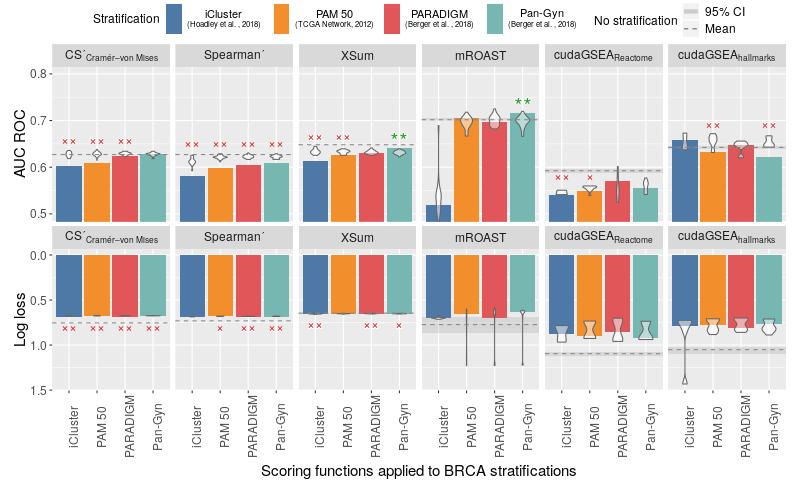

In [992]:
%%R -i bssrc_metrics -w 800 -u px

g = auc_log_plot(bssrc_metrics, auc_max=0.8, log_loss_max=NA)
ggsave(file="stratification_performance_bssrc.png", plot=g, width=8*1.3, height=5*1.3, dpi=140)
g

- Which new drugs were recovered? were those maybe metastatis related subtypes?
- XSum/mROAST - useless with this approach. The scores distributions issue?

In [81]:
def z_score(x):
    return (x - x.mean()) / x.std()

In [82]:
drug_categories = {
    'methotrexate': 'multi_cancer',
    'neratinib': 'HER2+',
    'cyclophosphamide': 'multi_cancer',
    'epirubicin': 'breast_cancer', # cytotoxic
    'tamoxifen': 'HR+',
    'everolimus': 'HR+, HER2-',
    'vinblastine': 'multi_cancer',
    'doxorubicin': 'multi_cancer', # cytotoxic
    'formestane': 'HR+',
    'palbociclib': 'HR+, HER2-',
    'thiotepa': 'multi_cancer',
    'docetaxel': 'multi_cancer',
    'lapatinib': 'HER2+',
    'paclitaxel': 'multi_cancer'
}

In [83]:
def scores_difference(reference, scores, drug_categories, groups=['indications']):
    key = ['pert_iname', 'func']
    r = df_per_substance(reference.assign(
        stratification='No stratification')
    ).drop(['subtype'], axis=1)
    r = rename_for_plot(r, nice_names, stratification_nice_names)
    r.score = r.groupby(key).score.transform('mean')
    r = r.drop_duplicates(key).drop('repeat', axis=1)
    p = scores[scores.group.isin(groups)]
    ri = r[r.group.isin(groups)]
    key = ['func', 'stratification']
    p.score = p.groupby(key).score.apply(z_score)
    ri.score = ri.groupby(key).score.apply(z_score)
    ref = ri.set_index(['func', 'pert_iname'])
    p.score = p.apply(lambda x:
        x['score'] - ref.loc[x['func'], x['pert_iname']].score
    , axis=1)
    p = p.drop('repeat', axis=1)
    assert not p.isnull().any().any()
    p['mean_score'] = p.groupby('pert_iname').score.transform('mean')
    p = p.sort_values('mean_score')
    p = p[p.group=='indications']
    p.pert_iname = pd.Categorical(p.pert_iname, ordered=True)
    p['category'] = p.pert_iname.apply(lambda x: drug_categories[x])
    p['is_subtype_specific'] = ~p['category'].isin(['multi_cancer', 'breast_cancer'])
    p.func = pd.Categorical(p.func)
    p.stratification = p.stratification.map(stratification_nice_names)
    p.stratification = pd.Categorical(p.stratification, ordered=True, categories=stratification_nice_names.values())
    return p

In [84]:
diff_max = scores_difference(scores_of_selected_functions, max_scores, drug_categories)

In [85]:
def test_subtype_specific_drgs_score_change_enrichment(p, by=['func'], alternative='less'):
    results = []
    for by_val, data in p.groupby(by):
        if len(by) == 1:
            by_val = [by_val]
        specifics = data[data['is_subtype_specific']]
        generics = data[~data['is_subtype_specific']]
        results.append({
            **dict(zip(by, by_val)),
            **r_ks_test(specifics.score, generics.score, alternative=alternative)
        })
    df = DataFrame(results).drop('data.name', axis=1)
    def nice_format(x):
        if x < 0.1:
            return f'{x:.2e}'
        else:
            return f'{x:.2f}'
    df['label'] = df.apply(lambda x: f"D={nice_format(x['statistic'])}\np={nice_format(x['p.value'])}", axis=1)
    df.func = pd.Categorical(df.func)
    return df

In [86]:
p_values_subtype_max = test_subtype_specific_drgs_score_change_enrichment(
    diff_max, ['func', 'stratification']
)
p_values_subtype_max[p_values_subtype_max['p.value'] < 0.05]

,alternative,func,method,p.value,statistic,stratification,label
23,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.032049,0.708333,Pan-Gyn,D=0.71\np=3.20e-02


In [87]:
p_values_subtype_max_aggregate = test_subtype_specific_drgs_score_change_enrichment(
    diff_max
)
p_values_subtype_max_aggregate

,alternative,func,method,p.value,statistic,label
0,the CDF of x lies below that of y,CS'_{Cramér–von Mises},Two-sample Kolmogorov-Smirnov test,0.785785,9.375000e-02,D=9.38e-02\np=0.79
1,the CDF of x lies below that of y,Spearman',Two-sample Kolmogorov-Smirnov test,0.988166,2.083333e-02,D=2.08e-02\np=0.99
2,the CDF of x lies below that of y,XSum,Two-sample Kolmogorov-Smirnov test,1.000000,5.551115e-17,D=5.55e-17\np=1.00
3,the CDF of x lies below that of y,cudaGSEA_{Reactome},Two-sample Kolmogorov-Smirnov test,0.006718,4.270833e-01,D=0.43\np=6.72e-03
4,the CDF of x lies below that of y,cudaGSEA_{hallmarks},Two-sample Kolmogorov-Smirnov test,1.000000,5.551115e-17,D=5.55e-17\np=1.00
5,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.341501,1.979167e-01,D=0.20\np=0.34


In [199]:
%%R

trend_plot = function(p, pval, wrap='func ~ .') {
    levels(p$func) = latex_levels(p, 'func')
    levels(pval$func) = latex_levels(pval, 'func')
    e = c('score', 'mean_score')
    t= unique(
        p[
            p$is_subtype_specific,
            #!(names(p) %in% e)
        ]
    )

    (
        ggplot(p, aes(x=tidytext::reorder_within(pert_iname, score, func), y=score))
        + theme_bw()
        + geom_bar(stat='identity', aes(group=stratification, fill=stratification))
        + facet_wrap(wrap, scales='free', labeller=label_parsed)
        + theme(
            legend.position='top',
            legend.box='horizontal',
            axis.text.x=element_text(angle=90, hjust=1)
        )
        + tidytext::scale_x_reordered()
        + geom_hline(yintercept=0, linetype=5, color = "white", size=0.25)
        + xlab('Breast cancer drug')
        + ylab('Cumulative change in z-score of anticorrelation score in comparison with no stratification')
        + ggthemes::scale_fill_tableau(
            labels=startification_names,
            guide=(fill=guide_legend(
                title='Stratification',
                label.hjust=0,
                label.theme=element_text(
                    size=11,
                    margin=margin(t=-.15, b=-0.15, u='cm', l=-0.05, r=0.05)
                ),
                order=1
            ))
        )
        + geom_point(data=t, aes(y=0), shape=24, alpha=0.05, color='white', size=2.1)
        + geom_point(data=t, aes(y=0), shape=24, alpha=0.9, color='black')
        + geom_text(data=pval, aes(y=Inf, x=1, label=label), hjust=0, vjust=1.35, size=3.5, color='#333333')

    )
}

/home/krassowski/drug_discovery/code/helpers/temp.py:19: UserWarning: Failed to mount /tmp/drug_repositioning/ temporary file system.
Please run: sudo mount -t tmpfs -o size=2G tmpfs /tmp/drug_repositioning/
and reload the offending module.
  f'Failed to mount {root} temporary file system.\n'


In [171]:
# α = 0.05 / (6 * 3)
f'{α:.2e}'

'2.78e-03'

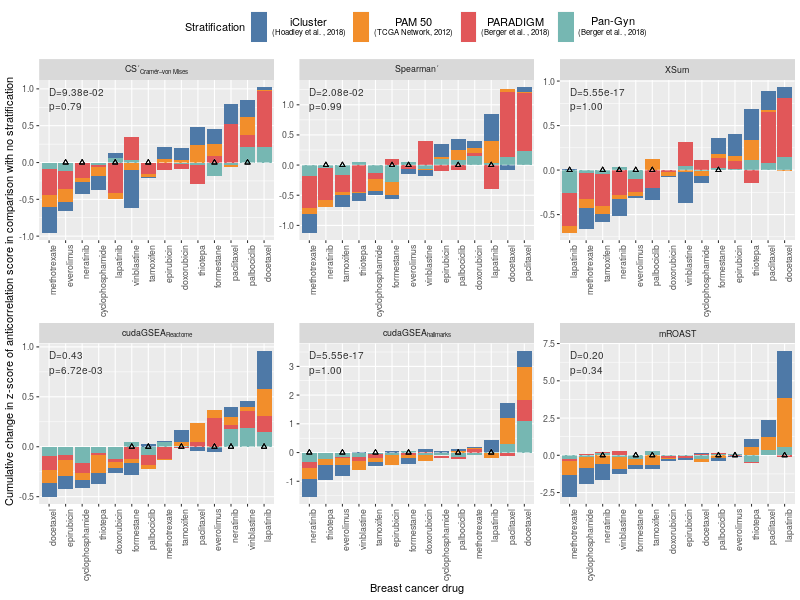

In [188]:
%%R -i diff_max -w 800 -u px -h 600 -i p_values_subtype_max_aggregate

g = trend_plot(diff_max, p_values_subtype_max_aggregate)
ggsave(file="indications_subtype_overall_trend_max.png", plot=g, width=8*1.3, height=6*1.3, dpi=120)
g

In [101]:
diff_mean = scores_difference(scores_of_selected_functions, weighted_mean_scores, drug_categories)

In [102]:
p_values_subtype_mean_aggregate = test_subtype_specific_drgs_score_change_enrichment(
    diff_mean
)
p_values_subtype_mean_aggregate

,alternative,func,method,p.value,statistic,label
0,the CDF of x lies below that of y,CS'_{Cramér–von Mises},Two-sample Kolmogorov-Smirnov test,6.047282e-01,0.135417,D=0.14\np=0.60
1,the CDF of x lies below that of y,Spearman',Two-sample Kolmogorov-Smirnov test,6.047282e-01,0.135417,D=0.14\np=0.60
2,the CDF of x lies below that of y,XSum,Two-sample Kolmogorov-Smirnov test,8.643017e-01,0.072917,D=7.29e-02\np=0.86
3,the CDF of x lies below that of y,cudaGSEA_{Reactome},Two-sample Kolmogorov-Smirnov test,2.413238e-03,0.468750,D=0.47\np=2.41e-03
4,the CDF of x lies below that of y,cudaGSEA_{hallmarks},Two-sample Kolmogorov-Smirnov test,5.580351e-01,0.145833,D=0.15\np=0.56
5,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,4.640222e-07,0.729167,D=0.73\np=4.64e-07


In [103]:
p_values_subtype_mean = test_subtype_specific_drgs_score_change_enrichment(
    diff_mean, ['func', 'stratification']
)
p_values_subtype_mean[p_values_subtype_mean['p.value'] < 0.05]

,alternative,func,method,p.value,statistic,stratification,label
22,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.005248,0.875,PARADIGM,D=0.88\np=5.25e-03
23,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.005248,0.875,Pan-Gyn,D=0.88\np=5.25e-03


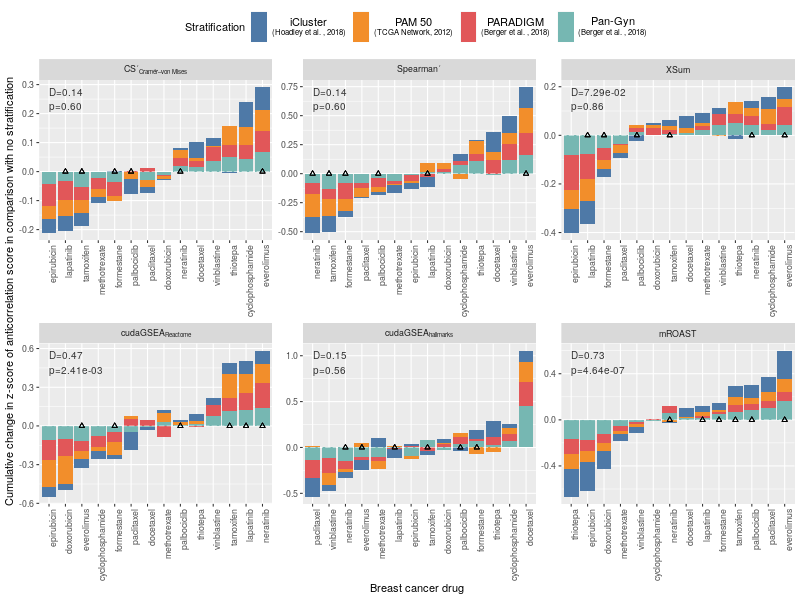

In [104]:
%%R -i diff_mean -w 800 -u px -h 600 -i p_values_subtype_mean_aggregate

g = trend_plot(diff_mean, p_values_subtype_mean_aggregate)
ggsave(file="indications_subtype_overall_trend_mean.png", plot=g, width=8*1.3, height=6*1.3, dpi=120)
g

In [105]:
diff_best = scores_difference(scores_of_selected_functions, bssrc_scores, drug_categories)

In [106]:
p_values_subtype_best_aggregate = test_subtype_specific_drgs_score_change_enrichment(
    diff_best
)
p_values_subtype_best_aggregate

,alternative,func,method,p.value,statistic,label
0,the CDF of x lies below that of y,CS'_{Cramér–von Mises},Two-sample Kolmogorov-Smirnov test,0.381255,0.187500,D=0.19\np=0.38
1,the CDF of x lies below that of y,Spearman',Two-sample Kolmogorov-Smirnov test,0.304076,0.208333,D=0.21\np=0.30
2,the CDF of x lies below that of y,XSum,Two-sample Kolmogorov-Smirnov test,0.604728,0.135417,D=0.14\np=0.60
3,the CDF of x lies below that of y,cudaGSEA_{Reactome},Two-sample Kolmogorov-Smirnov test,0.000320,0.541667,D=0.54\np=3.20e-04
4,the CDF of x lies below that of y,cudaGSEA_{hallmarks},Two-sample Kolmogorov-Smirnov test,0.006718,0.427083,D=0.43\np=6.72e-03
5,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.068661,0.312500,D=0.31\np=6.87e-02


In [107]:
p_values_subtype_best = test_subtype_specific_drgs_score_change_enrichment(
    diff_best, ['func', 'stratification']
)
p_values_subtype_best[p_values_subtype_best['p.value'] < 0.2]

,alternative,func,method,p.value,statistic,stratification,label
12,the CDF of x lies below that of y,cudaGSEA_{Reactome},Two-sample Kolmogorov-Smirnov test,0.096972,0.583333,iCluster,D=0.58\np=9.70e-02
13,the CDF of x lies below that of y,cudaGSEA_{Reactome},Two-sample Kolmogorov-Smirnov test,0.096972,0.583333,PAM 50,D=0.58\np=9.70e-02
14,the CDF of x lies below that of y,cudaGSEA_{Reactome},Two-sample Kolmogorov-Smirnov test,0.047472,0.666667,PARADIGM,D=0.67\np=4.75e-02
15,the CDF of x lies below that of y,cudaGSEA_{Reactome},Two-sample Kolmogorov-Smirnov test,0.133734,0.541667,Pan-Gyn,D=0.54\np=0.13
18,the CDF of x lies below that of y,cudaGSEA_{hallmarks},Two-sample Kolmogorov-Smirnov test,0.133734,0.541667,PARADIGM,D=0.54\np=0.13
20,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.096972,0.583333,iCluster,D=0.58\np=9.70e-02
21,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.180092,0.500000,PAM 50,D=0.50\np=0.18
23,the CDF of x lies below that of y,mROAST,Two-sample Kolmogorov-Smirnov test,0.180092,0.500000,Pan-Gyn,D=0.50\np=0.18


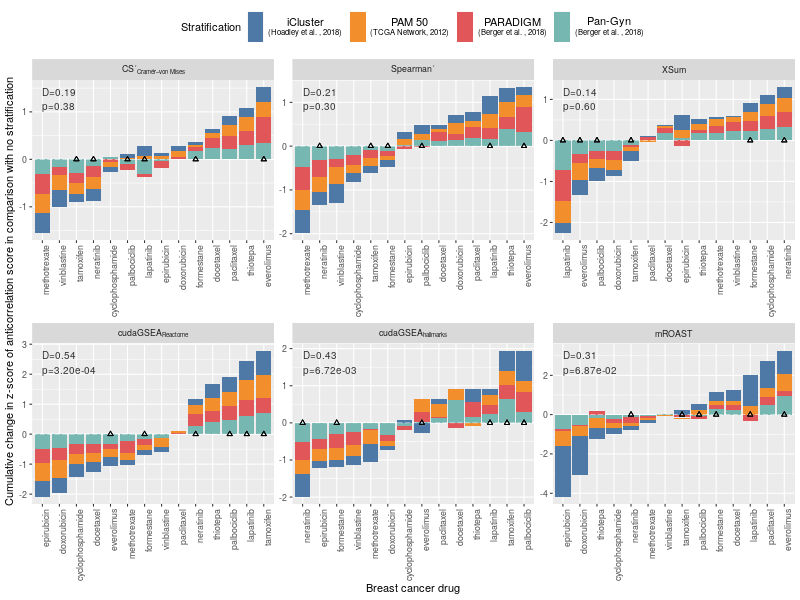

In [108]:
%%R -i diff_best -w 800 -u px -h 600 -i p_values_subtype_best_aggregate

g = trend_plot(diff_best, p_values_subtype_best_aggregate)
ggsave(file="indications_subtype_overall_trend_best.png", plot=g, width=8*1.3, height=6*1.3, dpi=120)
g

In [1169]:
diff_best

,func,group,is_indication,kind,pert_iname,score,stratification,mean_score,category,is_subtype_specific
278,cudaGSEA_{Reactome},indications,True,-,epirubicin,-0.532135,iCluster,-0.339195,breast_cancer,False
6902,XSum,indications,True,-,epirubicin,-0.512145,PARADIGM,-0.339195,breast_cancer,False
217,mROAST,indications,True,-,epirubicin,-2.582037,iCluster,-0.339195,breast_cancer,False
6835,Spearman',indications,True,-,epirubicin,-0.042577,PARADIGM,-0.339195,breast_cancer,False
9035,cudaGSEA_{Reactome},indications,True,-,epirubicin,-0.588860,PAM 50,-0.339195,breast_cancer,False
...,...,...,...,...,...,...,...,...,...,...
4786,CS'_{Cramér–von Mises},indications,True,-,paclitaxel,0.192948,Pan-Gyn,0.201120,multi_cancer,False
4991,mROAST,indications,True,-,paclitaxel,0.484417,Pan-Gyn,0.201120,multi_cancer,False
4922,XSum,indications,True,-,paclitaxel,-0.045073,Pan-Gyn,0.201120,multi_cancer,False
146,XSum,indications,True,-,paclitaxel,-0.038058,iCluster,0.201120,multi_cancer,False


- Worse log loss for GSEA methods - as expected.
- Spearman works well but only for certain stratifications

### significant findings only:

In [182]:
findings = {
    'mean': [diff_mean, p_values_subtype_mean_aggregate],
    'max': [diff_max, p_values_subtype_max_aggregate],
    'BSSRC': [diff_best, p_values_subtype_best_aggregate]
}
significant_findings = []
for name, (diff, p) in findings.items():
    significant_hits = p[p['p.value'] < α]
    
    significant_findings.append(
        diff[diff.func.isin(significant_hits.func)].assign(
            integration_strategy=name
        )
    )
significant_findings = concat(significant_findings)
significant_findings

,func,group,is_indication,kind,pert_iname,...,stratification,mean_score,category,is_subtype_specific,integration_strategy
217,mROAST,indications,True,-,epirubicin,...,iCluster,-0.083469,breast_cancer,False,mean
278,cudaGSEA_{Reactome},indications,True,-,epirubicin,...,iCluster,-0.083469,breast_cancer,False,mean
9035,cudaGSEA_{Reactome},indications,True,-,epirubicin,...,PAM 50,-0.083469,breast_cancer,False,mean
6972,mROAST,indications,True,-,epirubicin,...,PARADIGM,-0.083469,breast_cancer,False,mean
8962,mROAST,indications,True,-,epirubicin,...,PAM 50,-0.083469,breast_cancer,False,mean
...,...,...,...,...,...,...,...,...,...,...,...
5059,cudaGSEA_{Reactome},indications,True,-,thiotepa,...,Pan-Gyn,0.183646,multi_cancer,False,BSSRC
7047,cudaGSEA_{Reactome},indications,True,-,paclitaxel,...,PARADIGM,0.218261,multi_cancer,False,BSSRC
281,cudaGSEA_{Reactome},indications,True,-,paclitaxel,...,iCluster,0.218261,multi_cancer,False,BSSRC
9037,cudaGSEA_{Reactome},indications,True,-,paclitaxel,...,PAM 50,0.218261,multi_cancer,False,BSSRC


In [183]:
p_values_sig = test_subtype_specific_drgs_score_change_enrichment(
    significant_findings, ['func', 'integration_strategy']
)
p_values_sig

,alternative,func,integration_strategy,method,p.value,statistic,label
0,the CDF of x lies below that of y,cudaGSEA_{Reactome},BSSRC,Two-sample Kolmogorov-Smirnov test,3.198626e-04,0.541667,D=0.54\np=3.20e-04
1,the CDF of x lies below that of y,cudaGSEA_{Reactome},mean,Two-sample Kolmogorov-Smirnov test,2.413238e-03,0.468750,D=0.47\np=2.41e-03
2,the CDF of x lies below that of y,mROAST,mean,Two-sample Kolmogorov-Smirnov test,4.640222e-07,0.729167,D=0.73\np=4.64e-07


In [184]:
p_values_sig.func = p_values_sig.func.astype(str) + ' with ' + p_values_sig.integration_strategy
p_values_sig.func = pd.Categorical(p_values_sig.func)
significant_findings.func = significant_findings.func.astype(str) + ' with ' + significant_findings.integration_strategy
significant_findings.func = pd.Categorical(significant_findings.func)

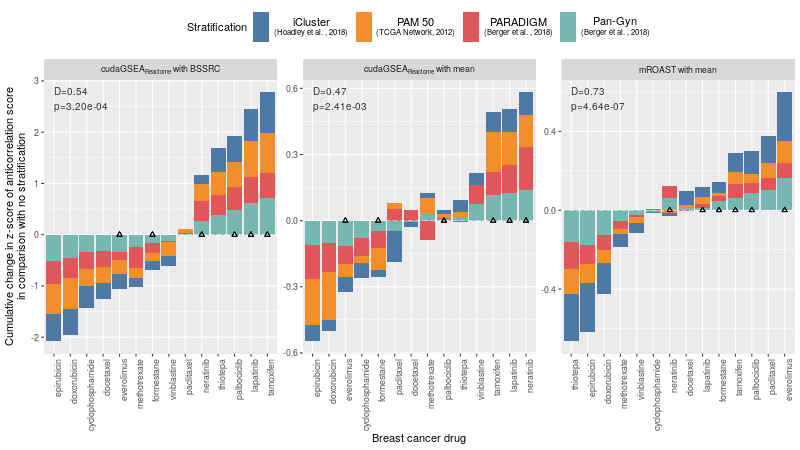

In [192]:
%%R -i significant_findings -w 800 -u px -h 450 -i p_values_sig

g = trend_plot(significant_findings, p_values_sig) + ylab('Cumulative change in z-score of anticorrelation score\nin comparison with no stratification')
ggsave(file="indications_subtype_overall_trend_significant_subset.png", plot=g, width=8*1.3, height=4.5*1.3, dpi=140)
g

In [1]:
%%R -i significant_findings -w 800 -u px -h 450 -i p_values_sig

g = trend_plot(significant_findings, p_values_sig) + ylab('Cumulative change in z-score of anticorrelation score\nin comparison with no stratification')
ggsave(file="indications_subtype_overall_trend_significant_subset_poster.png", plot=g, width=8*1.3, height=4.5*1.3, dpi=140)
g

UsageError: Cell magic `%%R` not found.


## Validation

### Validation using "witheld" subset from RepoDB

Method-function-stratification tuples of promising performance were testes on the validation subset from RepoDB

In [1]:
%store -r sel_scores

In [101]:
positive_validation_compounds = set(sel_scores[sel_scores.positive_validation==T].pert_iname)
negative_validation_compounds = set(sel_scores[sel_scores.negative_validation==T].pert_iname)

#### Using multi-sample mean scores

In [ ]:
mean_scores[multi_sample, all]

#### Using three, manually selected best candidates:

In [ ]:
bssrc_scores[cudaGSEA_hallmarks, icluster]
bssrc_scores[Spearman, Pan_Gyn]
max_metrics[mROAST, paradigm]

In [497]:
stratified_scores['positive_validation'] = stratified_scores.pert_iname.isin(positive_validation_compounds)
stratified_scores['negative_validation'] = stratified_scores.pert_iname.isin(negative_validation_compounds)

Substances of conflicting annotations were excluded:

stratified_scores.negative_validation & stratified_scores[stratified_scores.group=='indications']

In [ ]:
stratified_scores[stratified_scores.pert_iname.isin(negative_validation_compounds)]

In [465]:
stratified_scores[stratified_scores.group=='indications'].score.mean()

0.18139079984929216

In [466]:
.score.mean()

0.12504512433995235

In [467]:
stratified_scores[stratified_scores.pert_iname.isin(negative_validation_compounds)].score.mean()

0.12536527580650722

In [468]:
stratified_scores[stratified_scores.group=='contraindications'].score.mean()

0.12820236644373406

### Heatmap for Spearman

### Gene sets characteristic to successful subtypes

In [ ]:
(only the two multi-sample)

### Visualisation of score distributions by subtype of chosen stratification / metrics pairs:

In [ ]:
There are a few cases of special interest: iCluster/mRoast, Spearman (icluster, paradigm,, Pan-glyc)

### Possible confounders: relation with #clusters and #participants
- how does this relate to number of clusters? or number of mismatches participants? is there a correlation?

In [65]:
all_stratifications.groupby('group').cluster.unique()

group
icluster             [IC10, IC13, IC14, IC17, IC19, IC2, IC20, IC25...
pan_gyn_clusters                                  [C1, C2, C3, C4, C5]
paradigm_clusters                       [PRC2, PRC4, PRC5, PRC6, PRC8]
subtype_mrna         [Basal, Basal and Normal, Her2, Her2 and Norma...
Name: cluster, dtype: object

In [143]:
all_stratifications.groupby('group').cluster.apply(lambda x: len(set(x)))

group
icluster             12
pan_gyn_clusters      5
paradigm_clusters     5
subtype_mrna         10
Name: cluster, dtype: int64

This is averaged and has not much a chance to work. I nned to take max! Or max mean?

Overall, the methods perform similarly over different clusters. However 

## Are there enough permutations?

In [396]:
scores_all_permutations['perumutation_group'] = pd.Categorical(
    scores_all_permutations.stratification.str.split(' ').str[0]
)

In [401]:
for cat in ['stratification', 'func']:
    scores_all_permutations[cat] = pd.Categorical(scores_all_permutations[cat])

In [415]:
show_table(scores_all_permutations.groupby(['perumutation_group', 'func']).stratification.apply(lambda x: len(x.unique())).to_frame())

stratification
perumutation_group func                                                                                            
icluster           connectivity_score_signature_cramér_von_mises_difference                          124           
                   cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise  5             
                   cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise           5             
                   roast_score                                                                       5             
                   score_spearman                                                                    124           
                   x_sum                                                                             124           
pan_gyn_clusters   connectivity_score_signature_cramér_von_mises_difference                          124           
                   cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise  5             
                   cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise           5             
                   roast_score                                                                       27            
                   score_spearman                                                                    124           
                   x_sum                                                                             124           
paradigm_clusters  connectivity_score_signature_cramér_von_mises_difference                          124           
                   cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise  5             
                   cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise           5             
                   roast_score                                                                       27            
                   score_spearman                                                                    124           
                   x_sum                                                                             124           
subtype_mrna       connectivity_score_signature_cramér_von_mises_difference                          100           
                   cudaGSEA_1000_c2.cp.reactome_mean_0.5_fill_0_True_phenotype_twopass_signal2noise  70            
                   cudaGSEA_1000_h.all_mean_0.5_fill_0_True_phenotype_twopass_signal2noise           70            
                   roast_score                                                                       70            
                   score_spearman                                                                    100           
                   x_sum                                                                             100

In [410]:
scores_all_permutations

,Index,cell_id,func,group,is_indication,...,raw_score,score,stratification,subtype,perumutation_group
0,0,HCC515,connectivity_score_signature_cramér_von_mises_...,indications,True,...,69.775874,0.359850,icluster permutations (0),IC10,icluster
1,1,HCC515,connectivity_score_signature_cramér_von_mises_...,indications,True,...,64.454513,0.324958,icluster permutations (0),IC10,icluster
2,2,HCC515,connectivity_score_signature_cramér_von_mises_...,indications,True,...,56.127088,0.270355,icluster permutations (0),IC10,icluster
3,3,HCC515,connectivity_score_signature_cramér_von_mises_...,indications,True,...,49.933828,0.229745,icluster permutations (0),IC10,icluster
4,4,HCC515,connectivity_score_signature_cramér_von_mises_...,indications,True,...,7.489799,-0.048562,icluster permutations (0),IC10,icluster
...,...,...,...,...,...,...,...,...,...,...,...
1400,44,NaN,roast_score,contraindications,False,...,-0.023442,-0.470515,subtype_mrna permutations (69),BRCA.Normal,subtype_mrna
1401,45,NaN,roast_score,contraindications,False,...,-0.049120,-0.522299,subtype_mrna permutations (69),BRCA.Normal,subtype_mrna
1402,46,NaN,roast_score,contraindications,False,...,-0.049120,-0.522299,subtype_mrna permutations (69),BRCA.Normal,subtype_mrna
1403,47,NaN,roast_score,contraindications,False,...,-0.078492,-0.581534,subtype_mrna permutations (69),BRCA.Normal,subtype_mrna


If a scoring function generates worse results for a known stratification or no stratification than for a random stratification, I would not trust such a function. Therfore, XSum appears to be simply wrong at assessing the score.

It is not clear for cudaGSEA - it gets better scores for PAM 50 than random, but the random scores are better than no stratification at all - it suggests that the fact of stratification by itself makes the results appear better. One explanation would be that choosing the max is wrong as I need to choose min/max (extreme scores).

This demonstrates how looking at AUC alone can mislead when it comes to benefits of stratification. However, log loss of the random result is much worse for random stratification.

In [114]:
%store -r brca_expression_based_nmf_sub_types

In [116]:
scores_all_permutations

,Index,cell_id,func,group,is_indication,...,pert_iname,raw_score,score,stratification,subtype
0,0,PC3,connectivity_score_signature_cramér_von_mises_...,indications,True,...,everolimus,132.915379,0.933857,Random PAM50-like,BRCA.Basal
1,1,PC3,connectivity_score_signature_cramér_von_mises_...,indications,True,...,thiotepa,121.533503,0.847040,Random PAM50-like,BRCA.Basal
2,2,PC3,connectivity_score_signature_cramér_von_mises_...,indications,True,...,doxorubicin,65.816577,0.422048,Random PAM50-like,BRCA.Basal
3,3,PC3,connectivity_score_signature_cramér_von_mises_...,indications,True,...,palbociclib,55.654503,0.344535,Random PAM50-like,BRCA.Basal
4,4,PC3,connectivity_score_signature_cramér_von_mises_...,indications,True,...,tamoxifen,44.386852,0.258589,Random PAM50-like,BRCA.Basal
...,...,...,...,...,...,...,...,...,...,...,...
1400,44,NaN,roast_score,contraindications,False,...,fluphenazine,-0.050182,-0.575540,Random PAM50-like,BRCA.Normal
1401,45,NaN,roast_score,contraindications,False,...,oxymetholone,-0.083523,-0.646145,Random PAM50-like,BRCA.Normal
1402,46,NaN,roast_score,contraindications,False,...,oxymetholone,-0.083523,-0.646145,Random PAM50-like,BRCA.Normal
1403,47,NaN,roast_score,contraindications,False,...,iloperidone,-0.112666,-0.707861,Random PAM50-like,BRCA.Normal


In [115]:
#%store scores_all_permutations

Stored 'scores_all_permutations' (DataFrame)


### Validation

In [15]:
%store -r sel_scores

In [17]:
sel_scores[sel_scores.is_indication==True].percentile.mean()

0.36105164236049436

In [18]:
sel_scores[sel_scores.validation_group=='positive'].percentile.mean()

0.5784597270632325

In [470]:
weighted_scores.kind = weighted_scores.kind.fillna('single sample')

In [474]:
assert not weighted_scores.isnull().any().any()

In [476]:
stratified_scores = weighted_scores[weighted_scores.stratification != 'No stratification']
stratified_scores

,func,group,is_indication,kind,pert_iname,raw_score,score,stratification
0,CS'_{Cramér–von Mises},indications,True,single sample,doxorubicin,129.807215,0.254265,icluster
1,CS'_{Cramér–von Mises},indications,True,single sample,epirubicin,129.304073,0.256761,icluster
2,CS'_{Cramér–von Mises},indications,True,single sample,everolimus,103.118575,0.306796,icluster
3,CS'_{Cramér–von Mises},indications,True,single sample,neratinib,97.274341,0.067241,icluster
4,CS'_{Cramér–von Mises},indications,True,single sample,tamoxifen,94.950195,0.190336,icluster
...,...,...,...,...,...,...,...,...
49537,mROAST,contraindications,False,single sample,loxapine,-0.031838,0.076930,subtype_mrna
49538,mROAST,contraindications,False,single sample,fluoxetine,-0.032282,0.067859,subtype_mrna
49539,mROAST,contraindications,False,single sample,triflupromazine,-0.039953,0.062224,subtype_mrna
49540,mROAST,contraindications,False,single sample,triflupromazine,-0.039953,0.062224,subtype_mrna


In [19]:
sel_scores[sel_scores.validation_group=='negative'].percentile.mean()

0.407554631886752